# Plotting Distane from Present-Day Grounding Line

# 1. Load Dataset

In [1]:
import xarray as xr
import gcsfs
gcs = gcsfs.GCSFileSystem(token=None, access='read_only')

In [2]:
snapshots1ka = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/paleo_ensemble/snapshots1ka.zarr'))
snapshots1ka = snapshots1ka.chunk(chunks={'time':1})

In [3]:
# Add these codes to decrease CPU and memory use, which avoids the workers from being killed.
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()

# Close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
         cluster = gateway.connect(c.name)
         cluster.shutdown()  

# Increase worker memory
options = gateway.cluster_options()
options.worker_memory = 16

cluster = gateway.new_cluster(cluster_options=options)

[]


In [4]:
# Start up cloud cluster with 20 workers
cluster.scale(20)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.fe4a5fcf407d4286a421ba77e8b93586/status,


# 2. Define Section

To begin with, I determined two points to define a section in the Weddell Sea sector. The selected two points were (-1.5e6, 1.5e6) and (-0.7e6, 0). The analysis was performed on the condition with the following combination: present time, SIA enhancement factor = 2.0, q = 0.75, precipitation scaling factor = 2%/degree C, and vidcosity = 5E20 Pa S.

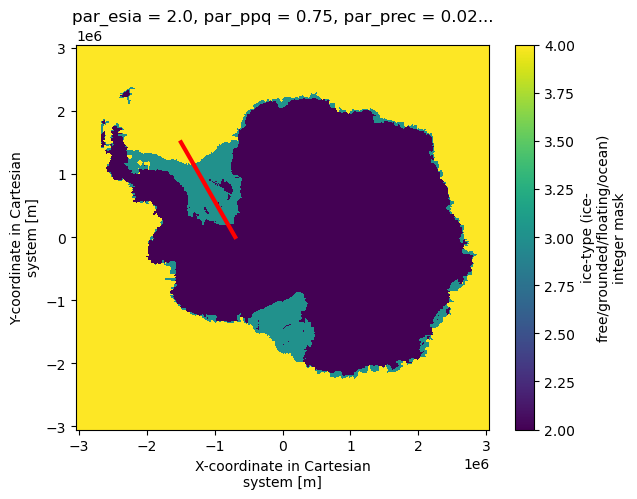

In [6]:
import matplotlib.pyplot as plt
snapshots1ka.mask.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=1).plot(x='x',y='y',size = 5)
x_p = [-1.5e6, -0.7e6]
y_p = [1.5e6, 0]
plt.plot(x_p,y_p,color="red", lw=3)

# 3. Determine the Grounding Line Position

Next, I used advanced interpolation to determine the position of the present-day grounding line on the defined section. I defined the point with mask = 2.5 to be the present-day grounding line because it is the transition point between grounded ice (mask = 2.0) and floating ice (mask = 3.0). For advanced interpolation, I created new xarray objects that correspond to the x- and y- coordinates.

In [41]:
import numpy as np
# the x coordinates for the 1000 points between points (-1.5e6,1.1e6) and (-0.7e6,0) are defined
x = np.linspace(x_p[0], x_p[1], 1000)
# the y coordinates for the 1000 points between points (-1.5e6,1.1e6) and (-0.7e6,0) are defined
y = np.linspace(y_p[0], y_p[1], 1000)

# create xarray datasets
x = xr.DataArray(x, dims="number")
y = xr.DataArray(y , dims="number")

In [42]:
# Advanced interpolation
ice = snapshots1ka.mask.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=1).interp(x=x, y=y).values
ice

array([4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.     

In [47]:
# the position of the grounding line
np.max(np.where(ice > 2.5))

875

The position of the grounding line was computed to be the 875th point on the section.

In [50]:
I_gl = np.max(np.where(ice > 2.5))

x_g = x[I_gl]
y_g = y[I_gl]

In [51]:
# compute the x- and y- coordinates for the grounding line position
print("x coordinate:", x_g)
print("y coordinate:", y_g)

x coordinate: <xarray.DataArray ()>
array(-799299.2992993)
y coordinate: <xarray.DataArray ()>
array(186186.18618619)


The plot below shows the position of the grounding line of the main ice sheet on the defined section.

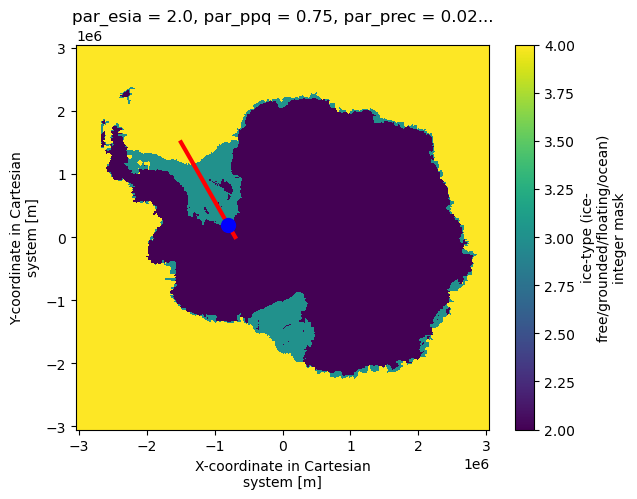

In [52]:
snapshots1ka.mask.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=1).plot(x='x',y='y',size = 5)
#x1 = [-1.5e6, -0.7e6]
#y1 = [1.5e6, 0]
plt.plot(x_p,y_p,color="red", lw=3)
plt.plot(x[I_gl], y[I_gl], color="blue", markersize=10,marker="o")

# Calculating the Distance from Grounding Line

Now that the position of the grounding line is determined, I will calculate the distance from the grounding line for each point on the defined section.

In [63]:
for i in range(0,I_gl):
    dist = (x[i]-GLx)**2 + (y[i]-GLy)**2
    dist = np.sqrt(dist)
    distance[i] = dist

for i in range(I_gl, len(x)):
    dist = (x[i]-GLx)**2 + (y[i]-GLy)**2
    dist = np.sqrt(dist)
    distance[i] = -dist

In [64]:
distance

[<xarray.DataArray ()>
 array(1488988.98898899),
 <xarray.DataArray ()>
 array(1487287.28728729),
 <xarray.DataArray ()>
 array(1485585.58558559),
 <xarray.DataArray ()>
 array(1483883.88388388),
 <xarray.DataArray ()>
 array(1482182.18218218),
 <xarray.DataArray ()>
 array(1480480.48048048),
 <xarray.DataArray ()>
 array(1478778.77877878),
 <xarray.DataArray ()>
 array(1477077.07707708),
 <xarray.DataArray ()>
 array(1475375.37537538),
 <xarray.DataArray ()>
 array(1473673.67367367),
 <xarray.DataArray ()>
 array(1471971.97197197),
 <xarray.DataArray ()>
 array(1470270.27027027),
 <xarray.DataArray ()>
 array(1468568.56856857),
 <xarray.DataArray ()>
 array(1466866.86686687),
 <xarray.DataArray ()>
 array(1465165.16516516),
 <xarray.DataArray ()>
 array(1463463.46346346),
 <xarray.DataArray ()>
 array(1461761.76176176),
 <xarray.DataArray ()>
 array(1460060.06006006),
 <xarray.DataArray ()>
 array(1458358.35835836),
 <xarray.DataArray ()>
 array(1456656.65665666),
 <xarray.DataArray (

# 5. Bedrock Surface Elevation

This section calculates the bedorck surface elevation for each point on the defined section using advanced interpolation. 

In [65]:
# Advanced interpolation
bed = snapshots1ka.topg.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=1).interp(x=x, y=y).values
bed

array([-3487.3679657 , -3481.40875428, -3475.41023164, -3469.37239778,
       -3463.2952527 , -3457.1787964 , -3451.02302889, -3444.82795015,
       -3438.58833996, -3431.68380403, -3424.78300405, -3417.88594003,
       -3410.99261196, -3404.10301985, -3397.21716369, -3390.33110231,
       -3383.14658364, -3375.88030285, -3368.53225996, -3360.59555792,
       -3351.66063958, -3342.66865908, -3333.61961642, -3324.51351161,
       -3315.35034464, -3306.13011551, -3296.85282422, -3287.51847078,
       -3278.12705518, -3268.67857743, -3258.68600236, -3248.46340646,
       -3238.2306462 , -3227.98772158, -3217.7346326 , -3207.45148166,
       -3196.61070649, -3185.7619801 , -3174.90530247, -3164.04067362,
       -3153.06521127, -3139.62438045, -3126.19820907, -3112.78669713,
       -3099.38984461, -3086.00765152, -3072.64011787, -3059.28724364,
       -3045.94902885, -3032.62547349, -3019.31657756, -3004.07433456,
       -2985.6814037 , -2967.2447216 , -2948.76428826, -2930.15147002,
      

# 6. Ice Thickness

This section calculates the ice thickness for each point on the defined section using advanced interpolation. 

In [56]:
# Advanced interpolation
ice = snapshots1ka.thk.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=1).interp(x=x, y=y).values
ice

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

# 7. Ice Upper Surface Elevation

This section calculates the ice upper surface elevatioin for each point on the defined section using advanced interpolation. 

In [66]:
# Advanced interpolation for surface
surface = snapshots1ka.usurf.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=1).interp(x=x, y=y).values
surface

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

# 8. Lower Level

This section calculates the lower level of the ice as (ice surface elevation) - (ice thickness)

In [67]:
low = surface - ice

# 9. Plot

In [68]:
# Convert distance to km
distance1 = [x / 1000 for x in distance]

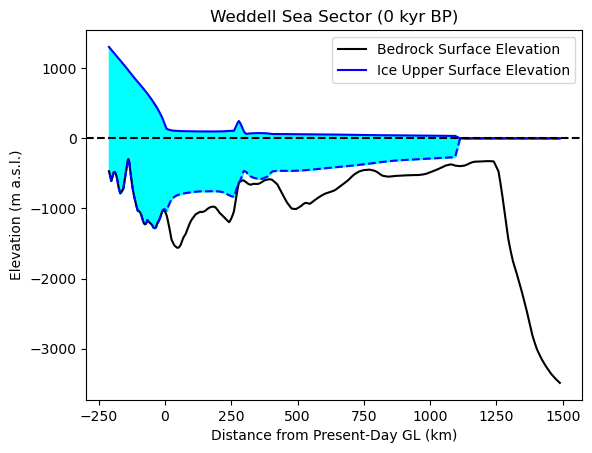

In [69]:
plt.plot(distance1,bed, color="black", label="Bedrock Surface Elevation")
plt.plot(distance1,surface, color="blue", label="Ice Upper Surface Elevation")
plt.plot(distance1, low, color="blue", linestyle="--")
plt.axhline(y = 0, color = 'black', linestyle = '--')
# The colored regions show the ice
plt.fill_between(distance1,surface, low, color='cyan')
plt.xlabel("Distance from Present-Day GL (km)")
plt.ylabel("Elevation (m a.s.l.)")
plt.title("Weddell Sea Sector (0 kyr BP)")
plt.legend()
plt.show()

In [70]:
cluster.shutdown()